In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib 
from scipy.stats import chi2_contingency
import numpy as np

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import kstest
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
import shap
from sklearn.model_selection import KFold


%matplotlib inline


In [2]:
#cleaned dataset
df = pd.read_csv("auto_data_cleaned_16_09_2024.csv")

# the models will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['model'])
df['Modell_encoded'] = target_encoder.fit_transform(df['model'], df['price_in_euro'])  # 'Preis' ist die Zielvariable


# the brand will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['brand'])
df['Brand_encoded'] = target_encoder.fit_transform(df['brand'], df['price_in_euro'])  # 'Preis' ist die Zielvariable

df=df.drop(columns=['year', 'offer_description', ])

df = pd.get_dummies(df, columns=[ 'fuel_type', 'transmission_type','color'], dtype='int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238302 entries, 0 to 238301
Data columns (total 36 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   brand                             238302 non-null  object 
 1   model                             238302 non-null  object 
 2   price_in_euro                     238302 non-null  float64
 3   power_ps                          238302 non-null  float64
 4   fuel_consumption_l_100km          238302 non-null  float64
 5   mileage_in_km                     238302 non-null  float64
 6   age                               238302 non-null  float64
 7   Modell_encoded                    238302 non-null  float64
 8   Brand_encoded                     238302 non-null  float64
 9   fuel_type_CNG                     238302 non-null  int64  
 10  fuel_type_Diesel                  238302 non-null  int64  
 11  fuel_type_Diesel Hybrid           238302 non-null  i

In [3]:
#cleaned dropped dataset
df_drop = pd.read_csv("auto_data_cleaned_drop__15_10_2024.csv")


# the models will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['model'])
df_drop['Modell_encoded'] = target_encoder.fit_transform(df['model'], df['price_in_euro'])  # 'Preis' ist die Zielvariable


# the brand will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['brand'])
df_drop['Brand_encoded'] = target_encoder.fit_transform(df['brand'], df['price_in_euro'])  # 'Preis' ist die Zielvariable

df_drop=df_drop.drop(columns=['year', 'offer_description'])

df_drop = pd.get_dummies(df_drop, columns=[ 'fuel_type', 'transmission_type','color'], dtype='int')
df_drop.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213668 entries, 0 to 213667
Data columns (total 36 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   brand                             213668 non-null  object 
 1   model                             213668 non-null  object 
 2   price_in_euro                     213668 non-null  float64
 3   power_ps                          213668 non-null  float64
 4   fuel_consumption_l_100km          213668 non-null  float64
 5   mileage_in_km                     213668 non-null  float64
 6   age                               213668 non-null  float64
 7   Modell_encoded                    213668 non-null  float64
 8   Brand_encoded                     213668 non-null  float64
 9   fuel_type_CNG                     213668 non-null  int64  
 10  fuel_type_Diesel                  213668 non-null  int64  
 11  fuel_type_Diesel Hybrid           213668 non-null  i

In [4]:
# Splitting the data into training and test sets
X = df.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y = df['price_in_euro']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of columns to scale
columns_to_scale = ['mileage_in_km', 'fuel_consumption_l_100km', 'Modell_encoded', 'power_ps','Brand_encoded','age']

# Initialize RobustScaler
scaler = RobustScaler()

# Scale features in X_train and X_test
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

# For y_train and y_test, reshape and apply scaling
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler.transform(y_test.values.reshape(-1, 1))

# Flatten both y_train and y_test back to 1D if needed
y_train = y_train.ravel()
y_test = y_test.ravel()


In [10]:
# Splitting the data into training and test sets
X_d = df_drop.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y_d = df_drop['price_in_euro']  # Target variable

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.2, random_state=42)

# List of columns to scale
columns_to_scale = ['mileage_in_km', 'fuel_consumption_l_100km', 'Modell_encoded', 'power_ps','Brand_encoded','age']

# Initialize RobustScaler
scaler = RobustScaler()

# Scale features in X_train and X_test
X_train_d[columns_to_scale] = scaler.fit_transform(X_train_d[columns_to_scale])
X_test_d[columns_to_scale] = scaler.transform(X_test_d[columns_to_scale])

# For y_train and y_test, reshape and apply scaling
y_train_d = scaler.fit_transform(y_train_d.values.reshape(-1, 1))
y_test_d = scaler.transform(y_test_d.values.reshape(-1, 1))

# Flatten both y_train and y_test back to 1D if needed
y_train_d = y_train_d.ravel()
y_test_d = y_test_d.ravel()


In [12]:
# Initialize K-NN model
knn = KNeighborsRegressor(n_neighbors=3)
knn_d = KNeighborsRegressor(n_neighbors=3)
# Define the cross-validation strategy (5-Fold in this case)

# Train the K-NN model
knn.fit(X_train, y_train)

# Train the K-NN model
knn_d.fit(X_train_d, y_train_d)

# Evaluate the K-NN model
knn_score = knn.score(X_test, y_test)
print(f'K-NN score -full dataset: {knn_score:.2f}')

y_pred = knn.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
print(f"Test Set MSE - full dataset: {mse_test}")
print(f"Test Set MAE - full datase: {mae_test}")

# Evaluate the K-NN_d model
knn_score_d = knn_d.score(X_test_d, y_test_d)
print(f'K-NN score - dropped dataset: {knn_score_d:.2f}')

y_pred_d = knn_d.predict(X_test_d)
mse_test_d = mean_squared_error(y_test_d, y_pred_d)
mae_test_d = mean_absolute_error(y_test_d, y_pred_d)
print(f"Test Set MSE - dropped data: {mse_test_d}")
print(f"Test Set MAE - dropped data: {mae_test_d}")

K-NN score -full dataset: 0.85
Test Set MSE - full dataset: 0.5554587636877101
Test Set MAE - full datase: 0.2334472169314688
K-NN score - dropped dataset: 0.67
Test Set MSE - dropped data: 1.0580078757070157
Test Set MAE - dropped data: 0.28046443224134143


In [13]:
# : Evaluate the model on the Test Set
y_pred = knn.predict(X_test)


# Inverse log transformation on both actual and predicted values
y_test_inv =  scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
#Inverse transform the predicted target variable 'y_pred'
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Calculate metrics on the original scale
mse_test = mean_squared_error(y_test_inv, y_pred_inv)
mae_test = mean_absolute_error(y_test_inv, y_pred_inv)
r2_test = r2_score(y_test_inv, y_pred_inv)

print(f"Test Set MSE - full dataset: {mse_test}")
print(f"Test Set MAE - full datase: {mae_test}")
print(f"Test Set R² - full dataset: {r2_test}")



# : Evaluate the model on the Test Set
y_pred_d = knn_d.predict(X_test_d)


# Inverse log transformation on both actual and predicted values
y_test_inv_d =  scaler.inverse_transform(y_test_d.reshape(-1, 1)).flatten()
#Inverse transform the predicted target variable 'y_pred'
y_pred_inv_d = scaler.inverse_transform(y_pred_d.reshape(-1, 1)).flatten()

# Calculate metrics on the original scale
mse_test_d = mean_squared_error(y_test_inv_d, y_pred_inv_d)
mae_test_d = mean_absolute_error(y_test_inv_d, y_pred_inv_d)
r2_test_d = r2_score(y_test_inv_d, y_pred_inv_d)

print(f"Test Set MSE - dropped data: {mse_test_d}")
print(f"Test Set MAE - dropped data: {mae_test_d}")
print(f"Test Set R² - dropped data: {r2_test_d}")



Test Set MSE - full dataset: 170303712.49252832
Test Set MAE - full datase: 4087.660768470019
Test Set R² - full dataset: 0.8479435245213941
Test Set MSE - dropped data: 324385320.4925587
Test Set MAE - dropped data: 4910.932208545889
Test Set R² - dropped data: 0.6669580308166745


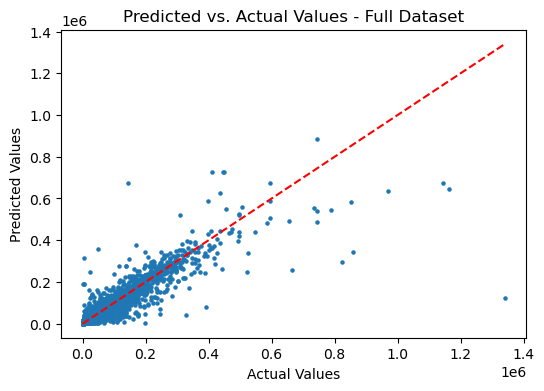

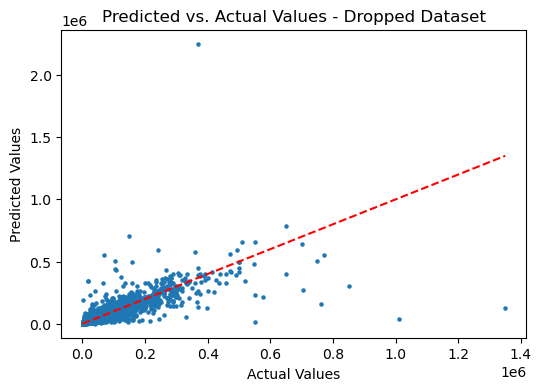

In [14]:
# Plot Predicted vs. Actual Values
plt.figure(figsize=(6,4))
plt.scatter(y_test_inv, y_pred_inv, s=5)
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], 'r--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values - Full Dataset')
plt.show()


# Plot Predicted vs. Actual Values for the Dropped dataset
plt.figure(figsize=(6,4))
plt.scatter(y_test_inv_d, y_pred_inv_d, s=5)
plt.plot([min(y_test_inv_d), max(y_test_inv_d)], [min(y_test_inv_d), max(y_test_inv_d)], 'r--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values - Dropped Dataset')
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

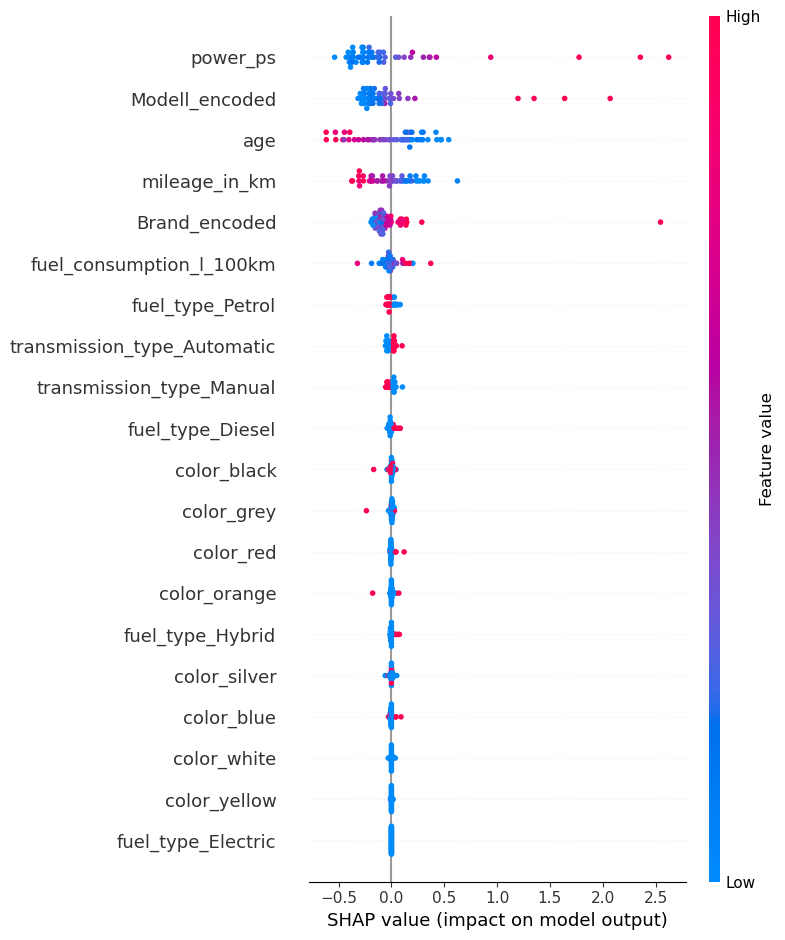

In [15]:

# Specify how many samples to use for SHAP calculations (e.g., 50 samples)
X_test_sampled = shap.sample(X_test, 50)
# Use the sampled data for KernelExplainer
explainer = shap.KernelExplainer(knn.predict, X_test_sampled)

# Get SHAP values for the sampled data
shap_values = explainer.shap_values(X_test_sampled)

# Create the SHAP summary plot
shap.summary_plot(shap_values, X_test_sampled)


  0%|          | 0/50 [00:00<?, ?it/s]

SHAP Values for knn model trained on dropped dataset


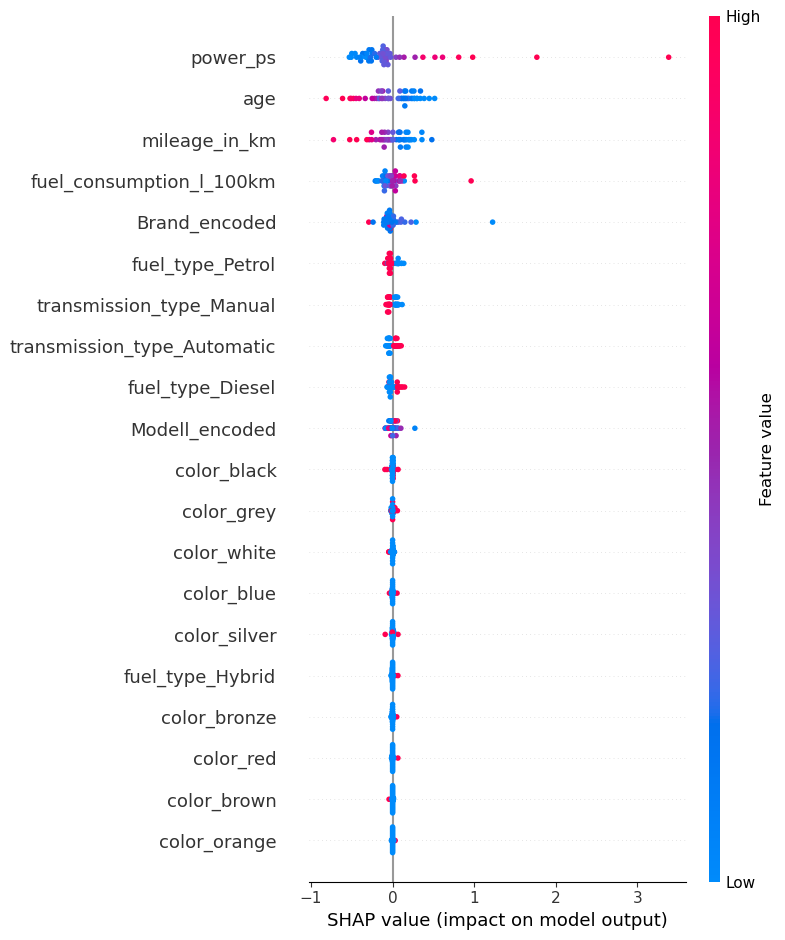

In [16]:

# Specify how many samples to use for SHAP calculations (e.g., 50 samples)
X_test_sampled = shap.sample(X_test_d, 50)
# Use the sampled data for KernelExplainer
explainer = shap.KernelExplainer(knn_d.predict, X_test_sampled)

# Get SHAP values for the sampled data
shap_values = explainer.shap_values(X_test_sampled)
print('SHAP Values for knn model trained on dropped dataset')
# Create the SHAP summary plot
shap.summary_plot(shap_values, X_test_sampled)


### 1. Feature Ranking (Y-axis):¶
The features are ranked in order of importance from top to bottom, with the most important features at the top. In my case, Model encoded, the age, power_ps are the most impactful features in predicting car prices, whereas color_red, brand_skoda, and other brand-mercedes-benz and other colors and brand variables have a lower impact. Interesting are transmission_type manual and automatic.

### 2. SHAP Value (X-axis):
The X-axis shows the SHAP values, which indicate the impact of each feature on the prediction (how much each feature pushes the prediction higher or lower). A positive SHAP value (to the right) means that the feature is pushing the prediction higher (toward a higher price). A negative SHAP value (to the left) means that the feature is pushing the prediction lower (toward a lower price). The further away a point is from zero, the greater its impact on the prediction.

### 3. Feature Value Color (Color Bar):
The color indicates the actual value of the feature for each observation. Blue represents lower values of the feature, while red represents higher values. For example, higher age (red) is pushing the car price lower, whereas lower age (blue) increases the car price.

### 4. Density of Points (Dots per row):
Each dot represents a single prediction for a specific data point. The spread of the points along the X-axis indicates how much a feature influences different predictions. For example, age has a wide range of SHAP values, meaning it has a significant effect on price predictions for many observations. Key Findings from the Plot: Age is a dominant factor, where older cars (red dots) decrease the price, and newer cars (blue dots) increase it. Power_ps (horsepower) also has a strong influence, where higher horsepower (red dots) increases the price, and lower horsepower (blue dots) decreases it. Modell_encoded encodes different car models, and the model of the car has a considerable influence on price. Some of the brand and color features have smaller SHAP values, suggesting they have a lower influence on the price predictions. This suggests that color might not be very significant, which aligns with my hypothesis that it could be dropped for specific models or use cases.

## I can see that both models showed difference in SHAP values. However, for both of them the model is not the most important

### I will try to search for the parameters whcih reduce the error: look scoring parameter for the GridSearchCV

In [17]:
knn_regressor = KNeighborsRegressor()

# Define the grid of hyperparameters to search
param_grid = {
    'n_neighbors': [3],  # Try k from 1 to 30
    'weights': ['uniform', 'distance'],
    'p': [1, 2],# Uniform or distance-based weights
  # p=1 (Manhattan), p=2 (Euclidean)
}

# Set up GridSearchCV with KNN Regressor and 5-fold cross-validation
grid_search = GridSearchCV(estimator=knn_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_knn_regressor = grid_search.best_estimator_

# Predict using the best estimator
y_pred = best_knn_regressor.predict(X_test)



# Calculate the R² score
r2 = r2_score(y_test, y_pred)

# Print the R² score
print(f"R² Score - Full data: {r2:.4f}")
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Calculate metrics on the original scale
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
print(f"Test Set MSE - Full data: {mse_test}")
print(f"Test Set MAE - full data: {mae_test}")
print(f"Test RMSE: {rmse:.2f}")

Best Parameters: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
R² Score - Full data: 0.8527
Test Set MSE - Full data: 0.5382412269601211
Test Set MAE - full data: 0.22745850626772934
Test RMSE: 0.73


In [18]:
#Inverting back the scaled y_test and y_pred
# : Evaluate the model on the Test Set
y_pred = best_knn_regressor.predict(X_test)


# Inverse log transformation on both actual and predicted values
y_test_inv =  scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
#Inverse transform the predicted target variable 'y_pred'
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Calculate metrics on the original scale
mse_test = mean_squared_error(y_test_inv, y_pred_inv)
mae_test = mean_absolute_error(y_test_inv, y_pred_inv)
r2_test = r2_score(y_test_inv, y_pred_inv)
rmse = mse_test ** 0.5

print(f"Test Set MSE - full dataset: {mse_test}")
print(f"Test Set MAE - full datase: {mae_test}")
print(f"Test Set R² - full dataset: {r2_test}")
print(f"Test RMSE: {rmse:.2f}")

Test Set MSE - full dataset: 165024814.0100958
Test Set MAE - full datase: 3982.7984447479403
Test Set R² - full dataset: 0.852656814008159
Test RMSE: 12846.20


In [19]:
knn_regressor = KNeighborsRegressor()

# Define the grid of hyperparameters to search
param_grid = {
    'n_neighbors': [3],  # Try k from 1 to 30
    'weights': ['uniform', 'distance'],
    'p': [1, 2],# Uniform or distance-based weights
  # p=1 (Manhattan), p=2 (Euclidean)
}

# Set up GridSearchCV with KNN Regressor and 5-fold cross-validation
grid_search = GridSearchCV(estimator=knn_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the model
grid_search.fit(X_train_d, y_train_d)

# Print the best parameters found
print("Best Parameters for neg_mean_absolute error:", grid_search.best_params_)

# Get the best model
best_knn_regressor = grid_search.best_estimator_

# Predict using the best estimator
y_pred_d = best_knn_regressor.predict(X_test_d)



# Calculate the R² score
r2 = r2_score(y_test_d, y_pred_d)

# Print the R² score
print(f"R² Score - Dropped data: {r2:.4f}")
# Evaluate the model
mse = mean_squared_error(y_test_d, y_pred_d)
rmse = mse ** 0.5
# Calculate metrics on the original scale
mse_test = mean_squared_error(y_test_d, y_pred_d)
mae_test = mean_absolute_error(y_test_d, y_pred_d)
print(f"Test Set MSE - Dropped data: {mse_test}")
print(f"Test Set MAE - Dropped data: {mae_test}")


print(f"Test RMSE: {rmse:.2f}")

Best Parameters for neg_mean_absolute error: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
R² Score - Dropped data: 0.6812
Test Set MSE - Dropped data: 1.012667378916118
Test Set MAE - Dropped data: 0.2642861056370435
Test RMSE: 1.01


In [22]:
#inverting the values of y_test and y_pred back

# : Evaluate the model on the Test Set
y_pred_d = knn.predict(X_test_d)


# Inverse scaling  transformation on both actual and predicted values
y_test_inv_d =  scaler.inverse_transform(y_test_d.reshape(-1, 1)).flatten()
#Inverse transform the predicted target variable 'y_pred'
y_pred_inv_d = scaler.inverse_transform(y_pred_d.reshape(-1, 1)).flatten()

# Calculate metrics on the original scale
mse_test = mean_squared_error(y_test_inv_d, y_pred_inv_d)
mae_test = mean_absolute_error(y_test_inv_d, y_pred_inv_d)
r2_test = r2_score(y_test_inv_d, y_pred_inv_d)
rmse = mse_test ** 0.5
print(f"Test Set MSE - Dropped dataset: {mse_test}")
print(f"Test Set MAE - Dropped datase: {mae_test}")
print(f"Test Set R² - Dropped dataset: {r2_test}")
print(f"Test RMSE: {rmse:.2f}")

Test Set MSE - Dropped dataset: 847515891.2597666
Test Set MAE - Dropped datase: 10003.733078390691
Test Set R² - Dropped dataset: 0.1298670330990246
Test RMSE: 29112.13


## Work with the dataset without the outliers:

In [5]:
#cleaned dataset
df = pd.read_csv("auto_data_cleaned_16_09_2024.csv")


# the models will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['model'])
df['Modell_encoded'] = target_encoder.fit_transform(df['model'], df['price_in_euro'])  # 'Preis' ist die Zielvariable
# the brand will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['brand'])
df['Brand_encoded'] = target_encoder.fit_transform(df['brand'], df['price_in_euro'])  # 'Preis' ist die Zielvariable

df=df.drop(columns=['year', 'offer_description', ])
df = pd.get_dummies(df, columns=[ 'fuel_type', 'transmission_type','color'], dtype='int')

# Remove outliers using Z-score for price and mileage
df_clean = df[(np.abs(stats.zscore(df['price_in_euro'])) < 8)]  # 4 is the higher threshold for outliers
df_clean = df_clean[(np.abs(stats.zscore(df_clean['mileage_in_km'])) < 4)]  # Do the same for mileage




In [6]:
#cleaned dropped dataset
df_drop = pd.read_csv("auto_data_cleaned_drop__15_10_2024.csv")


# the models will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['model'])
df_drop['Modell_encoded'] = target_encoder.fit_transform(df['model'], df['price_in_euro'])  # 'Preis' ist die Zielvariable


# the brand will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['brand'])
df_drop['Brand_encoded'] = target_encoder.fit_transform(df['brand'], df['price_in_euro'])  # 'Preis' ist die Zielvariable

df_drop=df_drop.drop(columns=['year', 'offer_description'])

df_drop = pd.get_dummies(df_drop, columns=[ 'fuel_type', 'transmission_type','color'], dtype='int')

# Remove outliers using Z-score for price and mileage
df_clean_d = df_drop[(np.abs(stats.zscore(df_drop['price_in_euro'])) < 8)]  # 4 is the higher threshold for outliers
df_clean_d = df_clean_d[(np.abs(stats.zscore(df_clean_d['mileage_in_km'])) < 4)]  # Do the same for mileage



In [7]:
print('The dimension of full dataset w/o outliers', df_clean.shape)
print('The dimension of dropped dataset w/o outliers', df_clean_d.shape)

The dimension of full dataset w/o outliers (237315, 36)
The dimension of dropped dataset w/o outliers (212863, 36)


In [8]:

# Splitting the data into training and test sets
X = df_clean.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y = df_clean['price_in_euro']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of columns to scale
columns_to_scale = ['mileage_in_km', 'fuel_consumption_l_100km', 'Modell_encoded', 'power_ps','Brand_encoded','age']

# Initialize RobustScaler
scaler_X = RobustScaler()

# Scale features in X_train and X_test
X_train[columns_to_scale] = scaler_X.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler_X.transform(X_test[columns_to_scale])

scaler=RobustScaler()
# For y_train and y_test, reshape and apply scaling
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler.transform(y_test.values.reshape(-1, 1))

# Flatten both y_train and y_test back to 1D if needed
y_train = y_train.ravel()
y_test = y_test.ravel()



In [123]:
# Splitting the data into training and test sets
X_d = df_clean_d.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y_d = df_clean_d['price_in_euro']  # Target variable

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.2, random_state=42)

# List of columns to scale
columns_to_scale = ['mileage_in_km', 'fuel_consumption_l_100km', 'Modell_encoded', 'power_ps','Brand_encoded','age']

# Initialize RobustScaler
scaler_X_d = RobustScaler()

# Scale features in X_train and X_test
X_train_d[columns_to_scale] = scaler_X_d.fit_transform(X_train_d[columns_to_scale])
X_test_d[columns_to_scale] = scaler_X_d.transform(X_test_d[columns_to_scale])

scaler_d=RobustScaler()
# For y_train and y_test, reshape and apply scaling
y_train_d = scaler_d.fit_transform(y_train_d.values.reshape(-1, 1))
y_test_d = scaler_d.transform(y_test_d.values.reshape(-1, 1))

# Flatten both y_train and y_test back to 1D if needed
y_train_d = y_train_d.ravel()
y_test_d = y_test_d.ravel()


In [129]:
# Initialize K-NN model
knn = KNeighborsRegressor(n_neighbors=7)
knn_d = KNeighborsRegressor(n_neighbors=7)
# Define the cross-validation strategy (5-Fold in this case)

# Train the K-NN model
knn.fit(X_train, y_train)

# Train the K-NN model
knn_d.fit(X_train_d, y_train_d)

# Evaluate the K-NN model
knn_score = knn.score(X_test, y_test)
print(f'K-NN score -full dataset: {knn_score:.2f}')

y_pred = knn.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
print(f"Test Set MSE - full dataset: {mse_test}")
print(f"Test Set MAE - full datase: {mae_test}")

# Evaluate the K-NN_d model
knn_score_d = knn_d.score(X_test_d, y_test_d)
print(f'K-NN score - dropped dataset: {knn_score_d:.2f}')

y_pred_d = knn_d.predict(X_test_d)
mse_test_d = mean_squared_error(y_test_d, y_pred_d)
mae_test_d = mean_absolute_error(y_test_d, y_pred_d)
print(f"Test Set MSE - dropped data: {mse_test_d}")
print(f"Test Set MAE - dropped data: {mae_test_d}")

K-NN score -full dataset: 0.90
Test Set MSE - full dataset: 0.19542936087133744
Test Set MAE - full datase: 0.20810068252755187
K-NN score - dropped dataset: 0.84
Test Set MSE - dropped data: 0.3005576164758082
Test Set MAE - dropped data: 0.2504767561860617


In [130]:
# : Evaluate the model on the Test Set
y_pred = knn.predict(X_test)


# Inverse log transformation on both actual and predicted values
y_test_inv =  scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
#Inverse transform the predicted target variable 'y_pred'
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Calculate metrics on the original scale
mse_test = mean_squared_error(y_test_inv, y_pred_inv)
mae_test = mean_absolute_error(y_test_inv, y_pred_inv)
r2_test = r2_score(y_test_inv, y_pred_inv)

print(f"Test Set MSE - full dataset: {mse_test}")
print(f"Test Set MAE - full datase: {mae_test}")
print(f"Test Set R² - full dataset: {r2_test}")



# : Evaluate the model on the Test Set
y_pred_d = knn_d.predict(X_test_d)


# Inverse log transformation on both actual and predicted values
y_test_inv_d =  scaler.inverse_transform(y_test_d.reshape(-1, 1)).flatten()
#Inverse transform the predicted target variable 'y_pred'
y_pred_inv_d = scaler.inverse_transform(y_pred_d.reshape(-1, 1)).flatten()

# Calculate metrics on the original scale
mse_test_d = mean_squared_error(y_test_inv_d, y_pred_inv_d)
mae_test_d = mean_absolute_error(y_test_inv_d, y_pred_inv_d)
r2_test_d = r2_score(y_test_inv_d, y_pred_inv_d)

print(f"Test Set MSE - dropped data: {mse_test_d}")
print(f"Test Set MAE - dropped data: {mae_test_d}")
print(f"Test Set R² - dropped data: {r2_test_d}")



Test Set MSE - full dataset: 60536198.823505476
Test Set MAE - full datase: 3662.572012484913
Test Set R² - full dataset: 0.9001862596064302
Test Set MSE - dropped data: 93100727.27954635
Test Set MAE - dropped data: 4408.390908874686
Test Set R² - dropped data: 0.8412746384961616


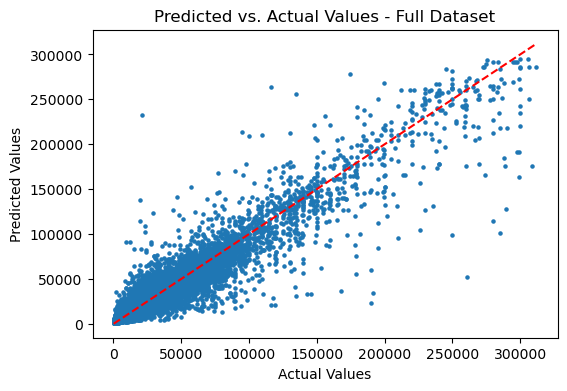

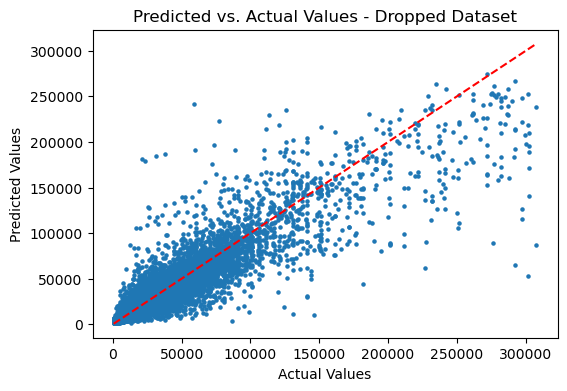

In [131]:
# Plot Predicted vs. Actual Values
plt.figure(figsize=(6,4))
plt.scatter(y_test_inv, y_pred_inv, s=5)
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], 'r--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values - Full Dataset')
plt.show()


# Plot Predicted vs. Actual Values for the Dropped dataset
plt.figure(figsize=(6,4))
plt.scatter(y_test_inv_d, y_pred_inv_d,  s=5)
plt.plot([min(y_test_inv_d), max(y_test_inv_d)], [min(y_test_inv_d), max(y_test_inv_d)], 'r--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values - Dropped Dataset')
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

SHAP Values for Full Dataset w/o Outliers


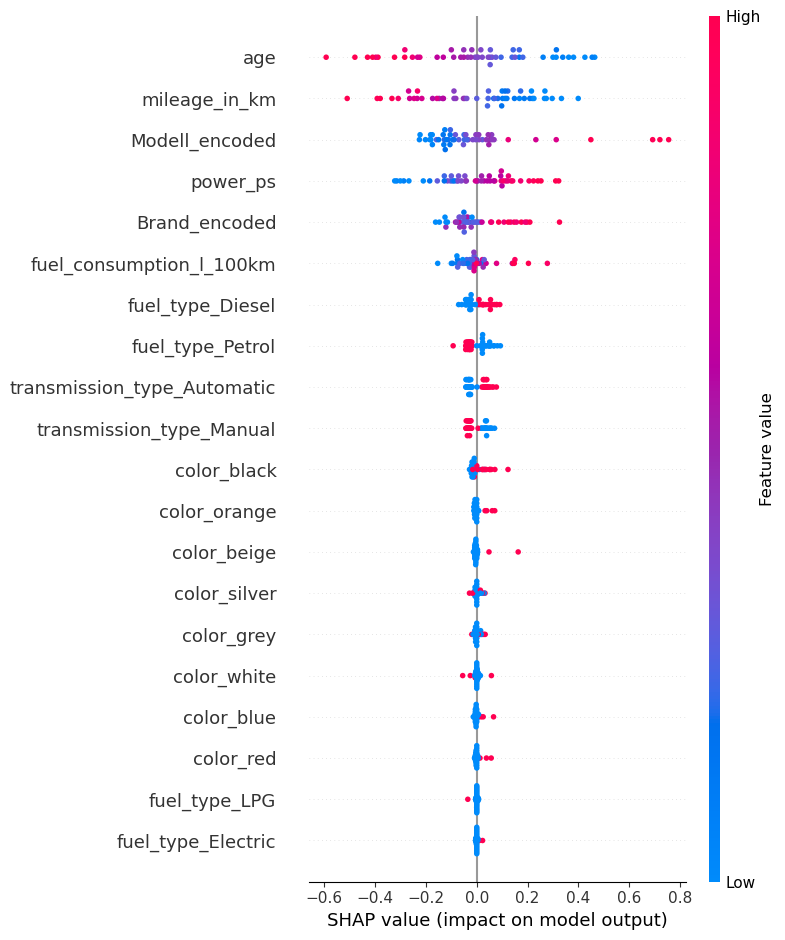

In [41]:

# Specify how many samples to use for SHAP calculations (e.g., 50 samples)
X_test_sampled = shap.sample(X_test, 50)
# Use the sampled data for KernelExplainer
explainer = shap.KernelExplainer(knn.predict, X_test_sampled)

# Get SHAP values for the sampled data
shap_values = explainer.shap_values(X_test_sampled)
print('SHAP Values for Full Dataset w/o Outliers')
# Create the SHAP summary plot
shap.summary_plot(shap_values, X_test_sampled)


  0%|          | 0/50 [00:00<?, ?it/s]

SHAP Values for knn model trained on dropped dataset


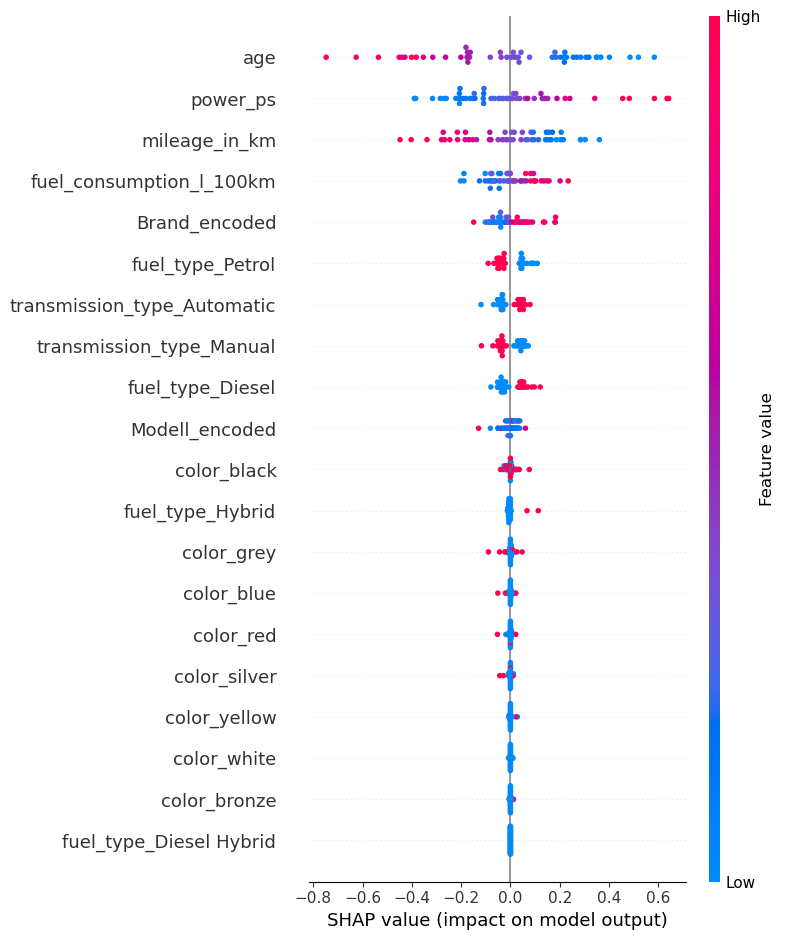

In [42]:
# Specify how many samples to use for SHAP calculations (e.g., 50 samples)
X_test_sampled = shap.sample(X_test_d, 50)
# Use the sampled data for KernelExplainer
explainer = shap.KernelExplainer(knn_d.predict, X_test_sampled)

# Get SHAP values for the sampled data
shap_values = explainer.shap_values(X_test_sampled)
print('SHAP Values for knn model trained on dropped dataset')
# Create the SHAP summary plot
shap.summary_plot(shap_values, X_test_sampled)

### Fine-tuning of parameters with Gridsearch CV

In [132]:
knn_regressor = KNeighborsRegressor()

# Define the grid of hyperparameters to search
param_grid = {
    'n_neighbors': [7],  # Try k from 1 to 30
    'weights': ['uniform', 'distance'],
    'p': [1, 2],# Uniform or distance-based weights
  # p=1 (Manhattan), p=2 (Euclidean)
}

# Set up GridSearchCV with KNN Regressor and 5-fold cross-validation
grid_search = GridSearchCV(estimator=knn_regressor, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_knn_regressor = grid_search.best_estimator_

# Predict using the best estimator
y_pred = best_knn_regressor.predict(X_test)



# Calculate the R² score
r2 = r2_score(y_test, y_pred)

# Print the R² score
print(f"R² Score - Full data: {r2:.4f}")


Best Parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
R² Score - Full data: 0.9088


In [133]:
#Inverting back the scaled y_test and y_pred
# : Evaluate the model on the Test Set
y_pred = best_knn_regressor.predict(X_test)


# Inverse scaling transformation on both actual and predicted values
y_test_inv =  scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
#Inverse transform the predicted target variable 'y_pred'
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Calculate metrics on the original scale
mse_test = mean_squared_error(y_test_inv, y_pred_inv)
mae_test = mean_absolute_error(y_test_inv, y_pred_inv)
r2_test = r2_score(y_test_inv, y_pred_inv)
rmse = mse_test ** 0.5

print(f"Test Set MSE - full dataset: {mse_test}")
print(f"Test Set MAE - full datase: {mae_test}")
print(f"Test Set R² - full dataset: {r2_test}")
print(f"Test RMSE: {rmse:.2f}")

Test Set MSE - full dataset: 55301256.4023347
Test Set MAE - full datase: 3396.9730295875065
Test Set R² - full dataset: 0.9088177758555003
Test RMSE: 7436.48


In [134]:
#the same for the dropped dataset (to compare)
knn_regressor = KNeighborsRegressor()

# Define the grid of hyperparameters to search
param_grid = {
    'n_neighbors': [7],  # Try k from 1 to 30
    'weights': ['uniform', 'distance'],
    'p': [1, 2],# Uniform or distance-based weights
  # p=1 (Manhattan), p=2 (Euclidean)
}

# Set up GridSearchCV with KNN Regressor and 5-fold cross-validation
grid_search = GridSearchCV(estimator=knn_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the model
grid_search.fit(X_train_d, y_train_d)

# Print the best parameters found
print("Best Parameters for neg_mean_absolute error:", grid_search.best_params_)

# Get the best model
best_knn_regressor = grid_search.best_estimator_

# Predict using the best estimator
y_pred = best_knn_regressor.predict(X_test_d)



# Calculate the R² score
r2 = r2_score(y_test_d, y_pred_d)

# Print the R² score
print(f"R² Score - Dropped data: {r2:.4f}")


Best Parameters for neg_mean_absolute error: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
R² Score - Dropped data: 0.8413


In [135]:
#inverting the values of y_test and y_pred back

# : Evaluate the model on the Test Set
y_pred_d = best_knn_regressor.predict(X_test_d)


# Inverse scaling  transformation on both actual and predicted values
y_test_inv_d =  scaler.inverse_transform(y_test_d.reshape(-1, 1)).flatten()
#Inverse transform the predicted target variable 'y_pred'
y_pred_inv_d = scaler.inverse_transform(y_pred_d.reshape(-1, 1)).flatten()

# Calculate metrics on the original scale
mse_test = mean_squared_error(y_test_inv_d, y_pred_inv_d)
mae_test = mean_absolute_error(y_test_inv_d, y_pred_inv_d)
r2_test = r2_score(y_test_inv_d, y_pred_inv_d)
rmse = mse_test ** 0.5
print(f"Test Set MSE - Dropped dataset: {mse_test}")
print(f"Test Set MAE - Dropped datase: {mae_test}")
print(f"Test Set R² - Dropped dataset: {r2_test}")
print(f"Test RMSE: {rmse:.2f}")

Test Set MSE - Dropped dataset: 76489152.43189377
Test Set MAE - Dropped datase: 4030.599892643601
Test Set R² - Dropped dataset: 0.8695953433916752
Test RMSE: 8745.81


In [9]:
# Model Initialization
knn_best = KNeighborsRegressor(n_neighbors=7, weights='distance', p=1)

# Train the K-NN model
knn_best.fit(X_train, y_train)

# Predict the target variable
y_pred = knn_best.predict(X_test)

# Inverse transform the predicted target variable 'y_pred'
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Inverse transform the scaled 'Modell_encoded' in X_test
X_test_inv = X_test.copy()  # Create a copy to store inverse-transformed data
X_test_inv[columns_to_scale] = scaler_X.inverse_transform(X_test[columns_to_scale])


# Step 2: Now we will use the scaled version of Modell_encoded for the merge
# Prepare DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual Price': y_test_inv,               # Already inverse transformed prices
    'Predicted Price': y_pred_inv,   
    'Residuals': y_pred_inv-y_test_inv,
    'Abs_residuals': abs(y_pred_inv-y_test_inv),# Already inverse transformed predictions
    'Modell_encoded': X_test_inv['Modell_encoded'],
    'Age': X_test_inv['age'],
    'Power': X_test_inv['power_ps']# Using scaled Modell_encoded for merging
})

# Step 3: Extract the original 'model' names from df_clean, including the scaled Modell_encoded
models_df = df_clean[['Modell_encoded', 'model']].drop_duplicates()  # Ensure unique Modell_encoded_scaled values

# Step 4: Merge the comparison DataFrame with models_df based on 'Modell_encoded_scaled'
final_comparison_df = pd.merge(comparison_df, models_df, on='Modell_encoded', how='left')

# View the final comparison DataFrame
final_comparison_df


,Actual Price,Predicted Price,Residuals,Abs_residuals,Modell_encoded,Age,Power,model
0,59900.0,59982.452352,82.452352,82.452352,113987.316378,17.0,385.0,Aston Martin V8
1,13750.0,13885.732900,135.732900,135.732900,9972.500162,6.0,75.0,Volkswagen Polo
2,7500.0,6704.944311,-795.055689,795.055689,12268.885175,14.0,101.0,NaN
3,19470.0,22240.541297,2770.541297,2770.541297,28201.139419,5.0,150.0,Volkswagen T-Roc
4,64450.0,60986.774941,-3463.225059,3463.225059,37938.626692,1.0,204.0,Land Rover Discovery Sport
...,...,...,...,...,...,...,...,...
47467,19990.0,19010.238752,-979.761248,979.761248,24236.931264,8.0,192.0,BMW 220
47468,16900.0,17823.089452,923.089452,923.089452,12938.947857,2.0,91.0,Renault Clio
47469,14990.0,16045.427007,1055.427007,1055.427007,18916.626652,5.0,131.0,Peugeot 308
47470,7990.0,9068.298880,1078.298880,1078.298880,17230.525216,14.0,120.0,Citroen Grand C4 Picasso


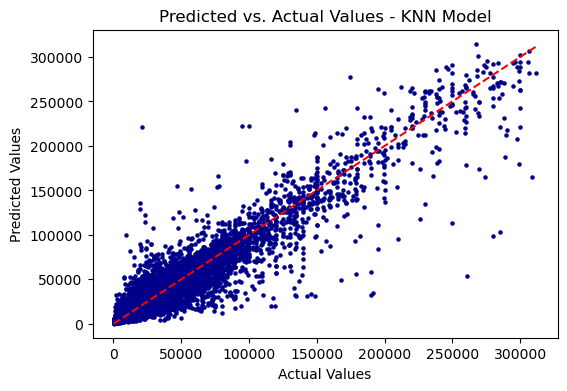

In [16]:
# Plot Predicted vs. Actual Values
plt.figure(figsize=(6,4))
plt.scatter(y_test_inv, y_pred_inv, s=5, color='darkblue')
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], 'r--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values - KNN Model')
plt.show()

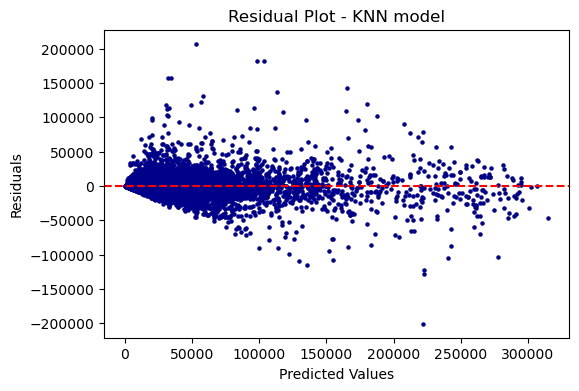

In [17]:
# Plot Residuals
residuals = y_test_inv - y_pred_inv
plt.figure(figsize=(6,4))
plt.scatter(y_pred_inv, residuals, s = 5, color='darkblue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - KNN model')
plt.show()

In [12]:
outlier_threshold = 2.5 * np.std(residuals)  # Set a threshold for residuals
outliers = final_comparison_df[abs(final_comparison_df['Residuals']) > outlier_threshold]
outliers.shape

(1110, 8)

  price_range  count
0        >50k    692
1     20k-30k    109
2     40k-50k    105
3     30k-40k     95
4     10k-20k     85
5        <10k     24


/var/folders/bg/6h6fxpzx7_v6jgvd0c31r_7m0000gn/T/ipykernel_42996/2961155811.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['price_range'] = pd.cut(outliers['Actual Price'], bins=bins, labels=labels)


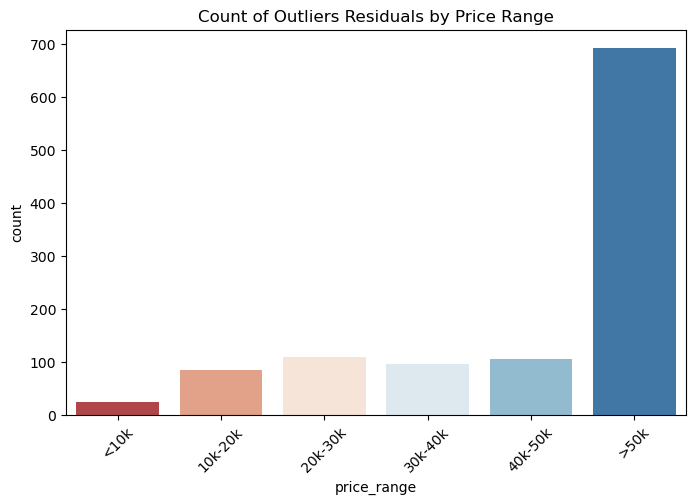

In [13]:
# Define price bins
bins = [0, 10000, 20000, 30000, 40000, 50000, float('inf')]
labels = ['<10k', '10k-20k', '20k-30k', '30k-40k', '40k-50k', '>50k']


# Create a new column for price ranges
outliers['price_range'] = pd.cut(outliers['Actual Price'], bins=bins, labels=labels)

# Group by price range
price_range_distribution = outliers['price_range'].value_counts().reset_index()
price_range_distribution.columns = ['price_range', 'count']

# Display the distribution
print(price_range_distribution)
# Visualize the price ranges
plt.figure(figsize=(8, 5))
sns.barplot(data=price_range_distribution, x='price_range', y='count', palette='RdBu')
plt.title('Count of Outliers Residuals by Price Range')
plt.xticks(rotation=45)
plt.show()

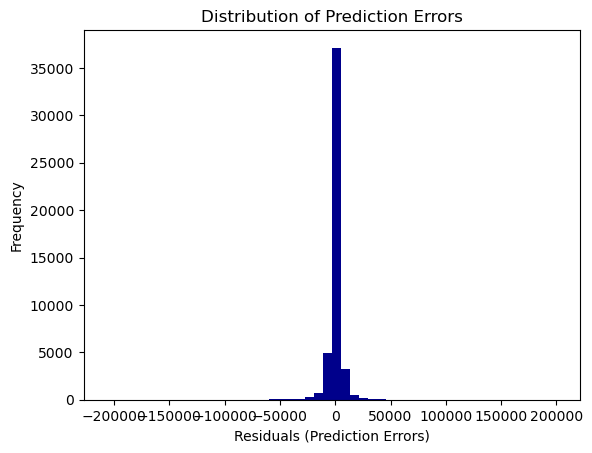

In [14]:
# Plot histogram of residuals
plt.hist(final_comparison_df['Residuals'], bins=50, color='darkblue')
plt.xlabel('Residuals (Prediction Errors)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()